# **Convolution Assignment**


### Uploading Kaggle API File and Downloading Dogs vs Cats dataset from Kaggle


In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"simrank30","key":"ca6168f5eb9fd496e0b838bac986b7bd"}'}

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle competitions download -c dogs-vs-cats
!unzip -qq dogs-vs-cats.zip
!unzip -qq train.zip

### Q1. Consider the Cats & Dogs example. Start initially with a training sample of 1000, a validation sample of 500, and a test sample of 500 (like in the text). Use any technique to reduce overfitting and improve performance in developing a network that you train from scratch. What performance did you achieve?




**Creating and Copying dataset to test, train and validation directory**

In [4]:
import os, shutil, pathlib
d_dir = pathlib.Path("train")
n_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = n_dir / subset_name / category
        os.makedirs(dir, exist_ok=True)

        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            src = d_dir / fname
            dst = dir / fname
            shutil.copyfile(src, dst)

make_subset("train", start_index=500, end_index=1500)
make_subset("validation", start_index=1500, end_index=2000)
make_subset("test", start_index=2000, end_index=2500)

**Building a basic model to classify dogs and cats using convolutional neural networks**

In [5]:
from tensorflow.keras.utils import image_dataset_from_directory

train_data = image_dataset_from_directory(n_dir / "train",image_size=(180, 180),batch_size=32)

valid_data = image_dataset_from_directory(n_dir / "validation",image_size=(180, 180),batch_size=32)

test_data= image_dataset_from_directory(n_dir / "test",image_size=(180, 180),batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


**Create an instance of the dataset using a NumPy array that has 1000 random samples with a vector size of 16**

In [6]:
import numpy as np
import tensorflow as tf

run_num = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(run_num)
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
       break

batch_data = dataset.batch(32)
for i, element in enumerate(batch_data):
    print(element.shape)
    if i >= 2:
       break

reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
       break

(16,)
(16,)
(16,)
(32, 16)
(32, 16)
(32, 16)
(4, 4)
(4, 4)
(4, 4)


**Displaying the shapes of the data and labels yielded by the Dataset**


In [7]:
for dataset_batch, label_batch in train_data:
    print("data batch shape:", dataset_batch.shape)
    print("labels batch shape:", label_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


**Identifying a small convolution for dogs vs. cats categories**

In [8]:
from tensorflow import keras
from tensorflow.keras import layers

input_1000 = keras.Input(shape=(180, 180, 3))
dat = layers.Rescaling(1./255)(input_1000)
dat = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(dat)
dat = layers.MaxPooling2D(pool_size=2)(dat)
dat = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(dat)
dat = layers.MaxPooling2D(pool_size=2)(dat)
dat = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(dat)
dat = layers.MaxPooling2D(pool_size=2)(dat)
dat = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(dat)
dat = layers.MaxPooling2D(pool_size=2)(dat)
dat = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(dat)
dat = layers.Flatten()(dat)
dat = layers.Dropout(0.5)(dat)
output_1000 = layers.Dense(1, activation="sigmoid")(dat)
model = keras.Model(inputs=input_1000, outputs=output_1000)

**Model Training**

In [9]:
model.compile(loss="binary_crossentropy",
optimizer="adam",
metrics=["accuracy"])

**The training dataset is used to train the model after it has been built. We use the validation dataset to verify the model's performance at the end of each epoch. I'm utilizing T4 GPU to reduce the time it takes for each epoch to execute**

In [10]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 18, 18, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 9, 9, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 7, 7, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │          12,545 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 991,041 (3.78 MB)

 Trainable params: 991,041 (3.78 MB)

 Non-trainable params: 0 (0.00 B)

**Model Fitting**

In [11]:
callbacks = [
keras.callbacks.ModelCheckpoint(
filepath="convnet_from_scratch.keras",
save_best_only=True,
monitor="val_loss")
]
history = model.fit(train_data,
epochs=100,
validation_data=valid_data,
callbacks=callbacks)

Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 172ms/step - accuracy: 0.4945 - loss: 0.7043 - val_accuracy: 0.5000 - val_loss: 0.6943
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.4816 - loss: 0.6957 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy: 0.5073 - loss: 0.6936 - val_accuracy: 0.5000 - val_loss: 0.6930
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.5213 - loss: 0.6923 - val_accuracy: 0.5030 - val_loss: 0.6928
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.5269 - loss: 0.6920 - val_accuracy: 0.4980 - val_loss: 0.6863
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - accuracy: 0.5411 - loss: 0.6883 - val_accuracy: 0.5340 - val_loss: 0.6860
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 55ms/step - accuracy: 0.5442 - loss: 0.6849 - val_accuracy: 0.5630 - val_loss: 0.6773
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.5964 - loss: 0.6571 - val_accuracy: 

**Curves of loss and accuracy during training**





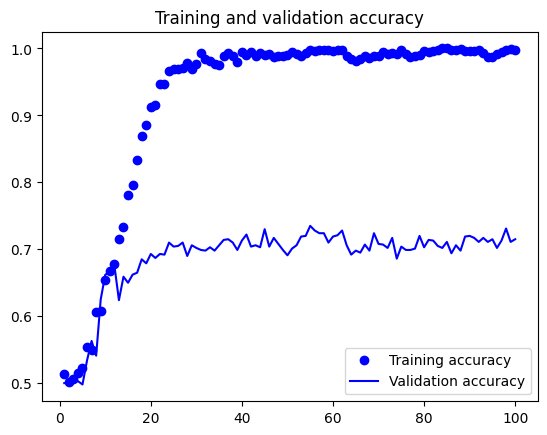

<Figure size 640x480 with 0 Axes>

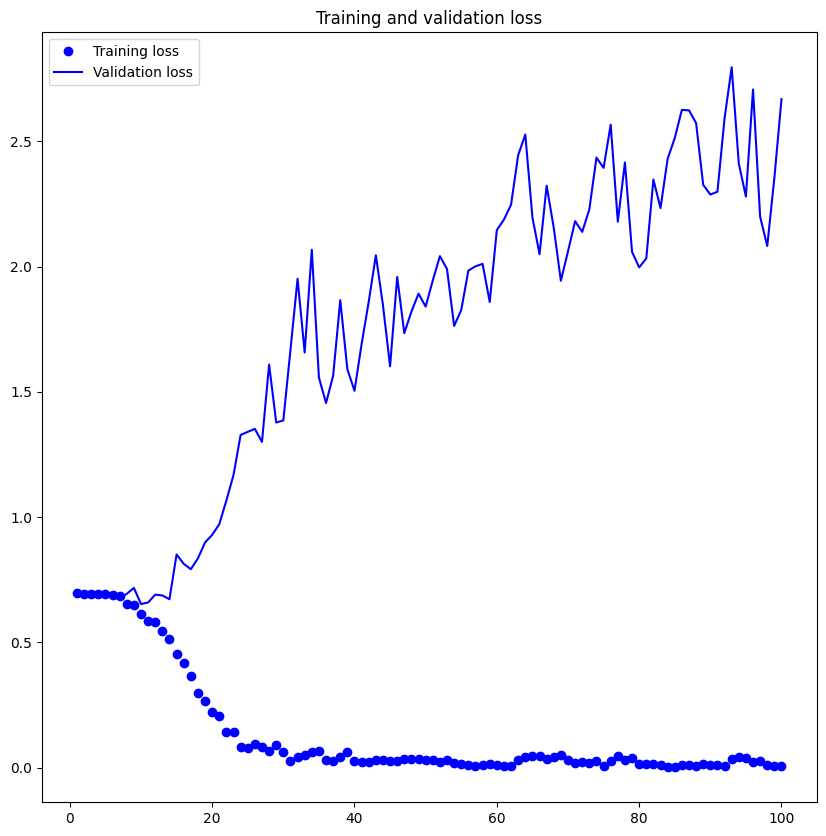

In [12]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.figure(figsize=(10, 10))
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

**Test Accuracy of model**

In [13]:
test = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test.evaluate(test_data)
print(f"Test accuracy: {test_acc:.3f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.6574 - loss: 0.6460
Test accuracy: 0.655


### Q2. Increase your training sample size. You may pick any amount. Keep the validation and test samples the same as above. Optimize your network (again training from scratch). What performance did you achieve?

**Using data augmentation**

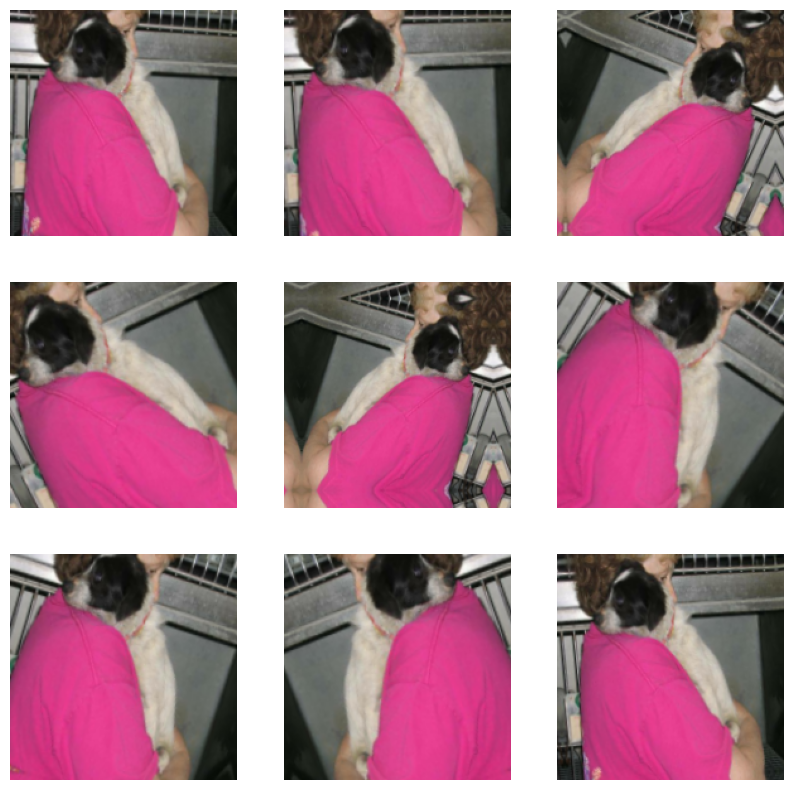

In [14]:
shutil.rmtree("./cats_vs_dogs_small_Q2", ignore_errors=True)
org_dir= pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_Q2")
def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=org_dir / fname,
            dst=dir / fname)

make_subset("train", start_index=667, end_index=2167)
make_subset("validation", start_index=2168, end_index=2668)
make_subset("test", start_index=2669, end_index=3168)
augmentation_info = keras.Sequential(
[
layers.RandomFlip("horizontal"),
layers.RandomRotation(0.1),
layers.RandomZoom(0.2),
]
)
plt.figure(figsize=(10, 10))
for images, _ in train_data.take(1):
    for i in range(9):
        augmented_images = augmentation_info(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

**Convolutional neural network with dropout and picture augmentation**

In [15]:
input = keras.Input(shape=(180, 180, 3))
data = augmentation_info(input)
data = layers.Rescaling(1./255)(data)
data= layers.Conv2D(filters=32, kernel_size=3, activation="relu")(data)
data = layers.MaxPooling2D(pool_size=2)(data)
data = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(data)
data = layers.MaxPooling2D(pool_size=2)(data)
data = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(data)
data = layers.MaxPooling2D(pool_size=2)(data)
data= layers.Conv2D(filters=256, kernel_size=3, activation="relu")(data)
data = layers.MaxPooling2D(pool_size=2)(data)
data = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(data)
data= layers.Flatten()(data)
data = layers.Dropout(0.5)(data)
output = layers.Dense(1, activation="sigmoid")(data)
model = keras.Model(inputs=input, outputs=output)
model.compile(loss="binary_crossentropy",
optimizer="adam",
metrics=["accuracy"])
callbacks= [
keras.callbacks.ModelCheckpoint(
filepath="convnet_from_scratch_with_augmentation_info.keras",
save_best_only=True,
monitor="val_loss")
]
hist = model.fit(
train_data,
epochs=50,
validation_data=valid_data,
callbacks=callbacks)

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.5208 - loss: 0.6921 - val_accuracy: 0.5400 - val_loss: 0.6926
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - accuracy: 0.5062 - loss: 0.6939 - val_accuracy: 0.5000 - val_loss: 0.6934
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.5237 - loss: 0.6927 - val_accuracy: 0.5060 - val_loss: 0.6920
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - accuracy: 0.5214 - loss: 0.6935 - val_accuracy: 0.5000 - val_loss: 0.6903
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.5557 - loss: 0.6874 - val_accuracy: 0.5520 - val_loss: 0.6831
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.5808 - loss: 0.6791 - val_accuracy: 0.6180 - val_loss: 0.6562
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - accuracy: 0.6317 - loss: 0.6613 - val_accuracy: 0.6160 - val_loss: 0.6626
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.6454 - loss: 0.6429 - val_accuracy: 0.6600 - 

**Curves of loss and accuracy during training were constructed**





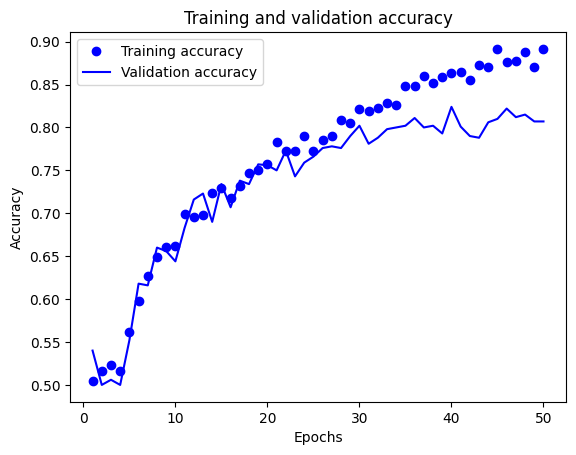

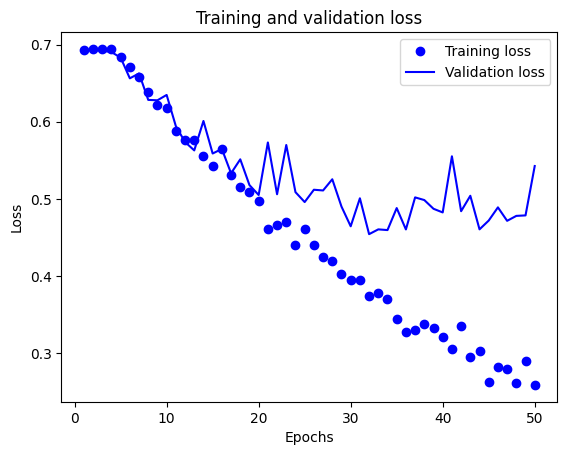

In [16]:
accuracy = hist.history["accuracy"]
val = hist.history["val_accuracy"]
loss = hist.history["loss"]
val_loss = hist.history["val_loss"]
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


**Test Accuracy of model**

In [17]:
testaccu = keras.models.load_model(
"convnet_from_scratch_with_augmentation_info.keras")
test_loss, test_acc = testaccu.evaluate(test_data)
print(f"Test accuracy: {test_acc:.3f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.7880 - loss: 0.4521
Test accuracy: 0.788


### Q3. Now change your training sample so that you achieve better performance than those from Steps 1 and 2. This sample size may be larger, or smaller than those in the previous steps. The objective is to find the ideal training sample size to get best prediction results.

**Increasing the training sample to 2000, keeping the Validation and test sets the same as before(500 samples)**

In [18]:
new_base_dir = pathlib.Path("cats_vs_dogs_small_Q3")
def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir,exist_ok=True)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=org_dir / fname,
            dst=dir / fname)
make_subset("train", start_index=500, end_index=2500)
make_subset("validation", start_index=2500, end_index=3000)
make_subset("test", start_index=3000, end_index=3500)
input= keras.Input(shape=(180, 180, 3))
data_1 = augmentation_info(input)
data_1 = layers.Rescaling(1./255)(data_1)
data_1= layers.Conv2D(filters=32, kernel_size=3, activation="relu")(data_1)
data_1 = layers.MaxPooling2D(pool_size=2)(data_1)
data_1 = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(data_1)
data_1= layers.MaxPooling2D(pool_size=2)(data_1)
data_1= layers.Conv2D(filters=128, kernel_size=3, activation="relu")(data_1)
data_1= layers.MaxPooling2D(pool_size=2)(data_1)
data_1= layers.Conv2D(filters=256, kernel_size=3, activation="relu")(data_1)
data_1= layers.MaxPooling2D(pool_size=2)(data_1)
data_1= layers.Conv2D(filters=256, kernel_size=3, activation="relu")(data_1)
data_1 = layers.Flatten()(data_1)
data_1= layers.Dropout(0.5)(data_1)
output = layers.Dense(1, activation="sigmoid")(data_1)
model = keras.Model(inputs=input, outputs=output)
model.compile(loss="binary_crossentropy",
optimizer="adam",
metrics=["accuracy"])
callback = [
keras.callbacks.ModelCheckpoint(
filepath="convnet_from_scratch_with_augmentation_info.keras",
save_best_only=True,
monitor="val_loss")
]
hist = model.fit(
train_data,
epochs=50,
validation_data=valid_data,
callbacks=callback)

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 87ms/step - accuracy: 0.5315 - loss: 0.7036 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.4874 - loss: 0.6936 - val_accuracy: 0.5000 - val_loss: 0.6926
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.5117 - loss: 0.6933 - val_accuracy: 0.5810 - val_loss: 0.6808
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - accuracy: 0.5366 - loss: 0.6909 - val_accuracy: 0.5290 - val_loss: 0.6857
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.5491 - loss: 0.6799 - val_accuracy: 0.6050 - val_loss: 0.6867
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.5856 - loss: 0.6810 - val_accuracy: 0.5250 - val_loss: 0.6836
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.6081 - loss: 0.6709 - val_accuracy: 0.5420 - val_loss: 0.6859
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.5694 - loss: 0.6769 - val_accuracy: 0.6240 - v

**Curves of loss and accuracy during training**





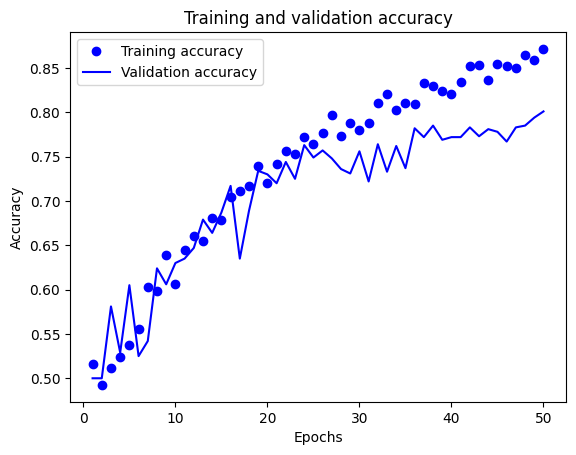

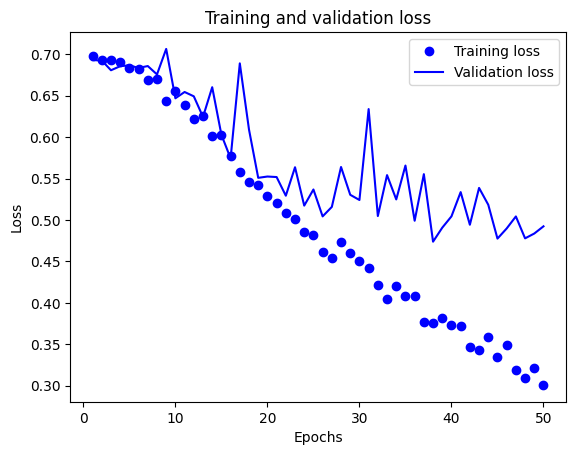

In [19]:
accuracy = hist.history["accuracy"]
validation = hist.history["val_accuracy"]
loss = hist.history["loss"]
valloss = hist.history["val_loss"]
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, validation, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, valloss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


**Test Accuracy of model**

In [20]:
testacc = keras.models.load_model(
"convnet_from_scratch_with_augmentation_info.keras")
test_loss, test_acc = testacc.evaluate(test_data)
print(f"Test accuracy: {test_acc:.3f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8076 - loss: 0.4412
Test accuracy: 0.807


### Q4. Repeat Steps 1-3, but now using a pretrained network. The sample sizes you use in Steps 2 and 3 for the pretrained network may be the same or different from those using the network where you trained from scratch. Again, use any and all optimization techniques to get best performance.

**Instantiating the VGG16 convolutional base**

In [21]:
convoluted = keras.applications.vgg16.VGG16(
weights="imagenet",
include_top=False,
input_shape=(180, 180, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [22]:
convoluted.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 180, 180, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 180, 180, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 90, 90, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 90, 90, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 45, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 45, 45, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 45, 45, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 45, 45, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 22, 22, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 22, 22, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 22, 22, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 22, 22, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 11, 11, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 5, 5, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

**pretrained model for feature extraction without data augmentation**

In [23]:
def get_features_and_labels(dataset):
    all_feature = []
    all_label = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = convoluted.predict(preprocessed_images)
        all_feature.append(features)
        all_label.append(labels)
    return np.concatenate(all_feature), np.concatenate(all_label)
train_features, train_labels = get_features_and_labels(train_data)
val_features, val_labels = get_features_and_labels(valid_data)
test_features, test_labels = get_features_and_labels(test_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

In [24]:
train_features.shape

(2000, 5, 5, 512)

**Model Fitting**

In [25]:
input = keras.Input(shape=(5, 5, 512))
data_2 = layers.Flatten()(input)
data_2 = layers.Dense(256)(data_2)
data_2 = layers.Dropout(0.5)(data_2)
out = layers.Dense(1, activation="sigmoid")(data_2)
model = keras.Model(input, out)
model.compile(loss="binary_crossentropy",
optimizer="rmsprop",
metrics=["accuracy"])
callback= [
keras.callbacks.ModelCheckpoint(
filepath="feature_extraction.keras",
save_best_only=True,
monitor="val_loss")
]
history = model.fit(
train_features, train_labels,
epochs=50,
validation_data=(val_features, val_labels),
callbacks=callback)

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.8847 - loss: 20.2652 - val_accuracy: 0.9360 - val_loss: 11.2583
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9700 - loss: 5.9747 - val_accuracy: 0.9680 - val_loss: 5.1160
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9858 - loss: 1.8320 - val_accuracy: 0.9650 - val_loss: 5.3081
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9889 - loss: 1.7436 - val_accuracy: 0.9630 - val_loss: 9.5102
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9956 - loss: 0.7284 - val_accuracy: 0.9660 - val_loss: 6.8998
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9961 - loss: 0.6813 - val_accuracy: 0.9730 - val_loss: 4.7798
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9968 - loss: 0.2714 - val_accuracy: 0.9720 - val_loss: 4.9366
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9928 - loss: 0.6939 - val_accuracy: 0.9740 - val_lo

**Curves of loss and accuracy during training**

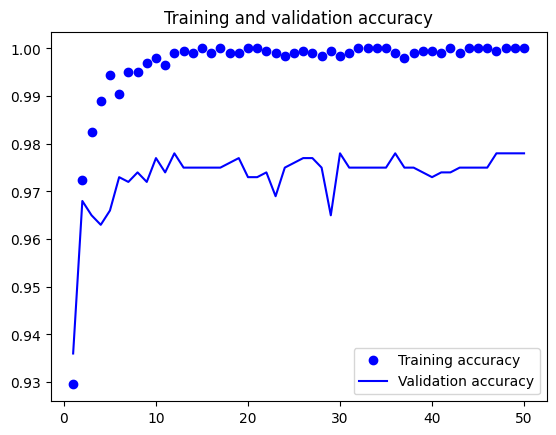

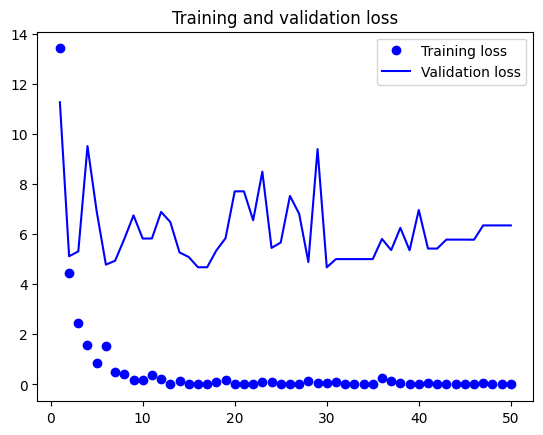

In [26]:
accur = history.history["accuracy"]
valac= history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accur) + 1)
plt.plot(epochs, accur, "bo", label="Training accuracy")
plt.plot(epochs, valac, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

**Freezing and Unfreezing the Pre-trained Convolutional Base**

In [27]:
convoluted = keras.applications.vgg16.VGG16(
weights="imagenet",
include_top=False)
convoluted.trainable = False
convoluted.trainable = True
print("This is the number of trainable weights "
"before freezing the conv base:", len(convoluted.trainable_weights))
convoluted.trainable = False
print("This is the number of trainable weights "
"after freezing the conv base:", len(convoluted.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26
This is the number of trainable weights after freezing the conv base: 0


**Model is now performing with a classifier and agumentation to convulation base**

In [28]:
augmented= keras.Sequential(
[
layers.RandomFlip("horizontal"),
layers.RandomRotation(0.1),
layers.RandomZoom(0.2),
]
)
input = keras.Input(shape=(180, 180, 3))
data_3= augmented(input)
data_3=keras.layers.Lambda(
lambda x: keras.applications.vgg16.preprocess_input(x))(data_3)
data_3= convoluted(data_3)
data_3 = layers.Flatten()(data_3)
data_3 = layers.Dense(256)(data_3)
data_3= layers.Dropout(0.5)(data_3)
outputs = layers.Dense(1, activation="sigmoid")(data_3)
model = keras.Model(input, outputs)
model.compile(loss="binary_crossentropy",
optimizer="rmsprop",
metrics=["accuracy"])
callback = [
keras.callbacks.ModelCheckpoint(
filepath="features_extraction_with_augmentation2.keras",
save_best_only=True,
monitor="val_loss"
)
]
history= model.fit(
train_data,
epochs=100,
validation_data=valid_data,
callbacks=callback
)

Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 198ms/step - accuracy: 0.8374 - loss: 31.7173 - val_accuracy: 0.9720 - val_loss: 3.3625
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 184ms/step - accuracy: 0.9522 - loss: 4.9237 - val_accuracy: 0.9800 - val_loss: 3.4469
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 175ms/step - accuracy: 0.9496 - loss: 5.6202 - val_accuracy: 0.9070 - val_loss: 24.4526
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 176ms/step - accuracy: 0.9562 - loss: 5.6396 - val_accuracy: 0.9690 - val_loss: 4.3521
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 180ms/step - accuracy: 0.9535 - loss: 6.4313 - val_accuracy: 0.9770 - val_loss: 4.4422
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 186ms/step - accuracy: 0.9626 - loss: 4.6558 - val_accuracy: 0.9770 - val_loss: 2.8894
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 144ms/step - accuracy: 0.9767 - loss: 1.7954 - val_accuracy: 0.9790 - val_loss: 3.3682
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 153ms/step - accuracy: 0.9775 - loss: 2.2424 

**Curves of loss and accuracy during training**





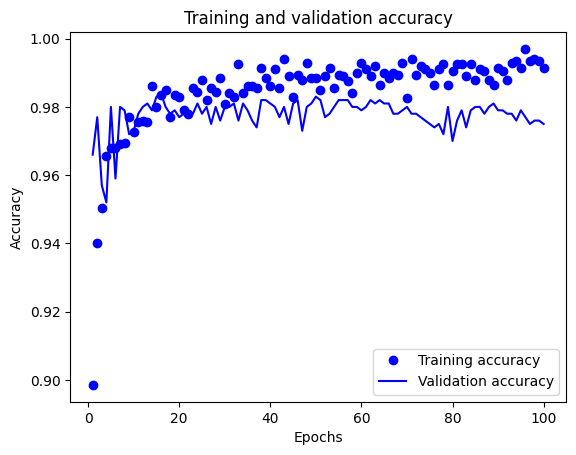

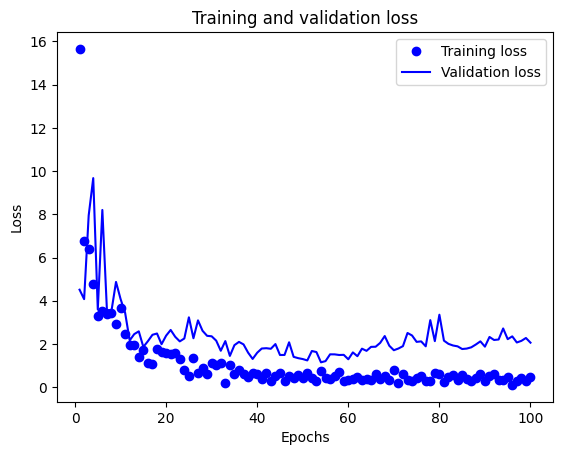

In [ ]:
accuracy_1 = history.history["accuracy"]
validation= history.history["val_accuracy"]
loss = history.history["loss"]
valloss = history.history["val_loss"]
epochs = range(1, len(accuracy_1) + 1)
plt.plot(epochs, accuracy_1, "bo", label="Training accuracy")
plt.plot(epochs, validation, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, valloss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


**Test Accuracy of model**

In [ ]:
tesaccuracy = keras.models.load_model(
"features_extraction_with_augmentation2.keras",safe_mode=False)
test_loss, test_acc = tesaccuracy.evaluate(test_data)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 4s 95ms/step - loss: 2.8497 - accuracy: 0.9670
Test accuracy: 0.967


**Fine-tuning a pretrained model**

In [ ]:
convoluted.trainable = True
for layer in convoluted.layers[:-4]:
    layer.trainable = False

model.compile(loss="binary_crossentropy",
optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
metrics=["accuracy"])
callback = [
keras.callbacks.ModelCheckpoint(
filepath="fine_tuning.keras",
save_best_only=True,
monitor="val_loss")
]
historytuning = model.fit(
train_data,
epochs=50,
validation_data=valid_data,
callbacks=callback)

Epoch 1/50
63/63 [==============================] - 14s 190ms/step - loss: 0.2360 - accuracy: 0.9925 - val_loss: 2.1644 - val_accuracy: 0.9780
Epoch 2/50
63/63 [==============================] - 12s 188ms/step - loss: 0.2228 - accuracy: 0.9930 - val_loss: 1.7981 - val_accuracy: 0.9770
Epoch 3/50
63/63 [==============================] - 12s 182ms/step - loss: 0.4866 - accuracy: 0.9935 - val_loss: 3.1030 - val_accuracy: 0.9750
Epoch 4/50
63/63 [==============================] - 13s 209ms/step - loss: 0.3216 - accuracy: 0.9940 - val_loss: 1.7541 - val_accuracy: 0.9780
Epoch 5/50
63/63 [==============================] - 13s 196ms/step - loss: 0.1992 - accuracy: 0.9950 - val_loss: 1.8541 - val_accuracy: 0.9780
Epoch 6/50
63/63 [==============================] - 11s 169ms/step - loss: 0.2046 - accuracy: 0.9940 - val_loss: 1.8240 - val_accuracy: 0.9740
Epoch 7/50
63/63 [==============================] - 11s 176ms/step - loss: 0.1288 - accuracy: 0.9960 - val_loss: 1.8414 - val_accuracy: 0.9760

**Curves of loss and accuracy during training**





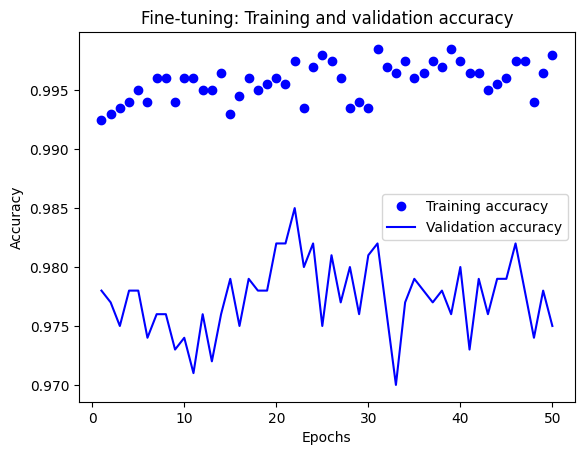

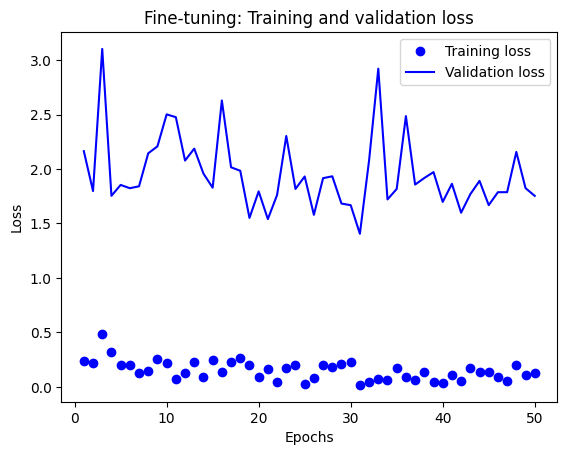

In [ ]:
accuracy_2= historytuning.history["accuracy"]
val_accuracy_tune = historytuning.history["val_accuracy"]
loss_tune = historytuning.history["loss"]
val_loss = historytuning.history["val_loss"]
epochs = range(1, len(accuracy_2) + 1)

plt.plot(epochs, accuracy_2, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy_tune, "b", label="Validation accuracy")
plt.title("Fine-tuning: Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, loss_tune, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Fine-tuning: Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


**Test Accuracy of model**

In [ ]:
tesaccuracy = keras.models.load_model(
"fine_tuning.keras",safe_mode=False)
test_loss, test_acc = tesaccuracy.evaluate(test_data)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 4s 99ms/step - loss: 3.0953 - accuracy: 0.9770
Test accuracy: 0.977
